<a href="https://colab.research.google.com/github/dikoharyadhanto/Data-Analysis-for-E-Commerce-Challenge/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [ ]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

Cloning into 'Coursera-Content'...
remote: Enumerating objects: 3049, done.
remote: Counting objects: 100% (3049/3049), done.
remote: Compressing objects: 100% (3046/3046), done.
remote: Total 3049 (delta 1), reused 3043 (delta 0), pack-reused 0
Receiving objects: 100% (3049/3049), 79.25 MiB | 21.30 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Import necessary Libraries 

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [ ]:
# Create Directory for Training Data
os.mkdir("/content/Crop-Brain-MRI") #mkdir is the function name for making directory
os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [ ]:
# Create Directory for Testing Data
os.mkdir("/content/Test-Data") #mkdir is the function name for making directory
os.mkdir("/content/Test-Data/glioma_tumor")
os.mkdir("/content/Test-Data/meningioma_tumor")
os.mkdir("/content/Test-Data/no_tumor")
os.mkdir("/content/Test-Data/pituitary_tumor")

## Data Visualization

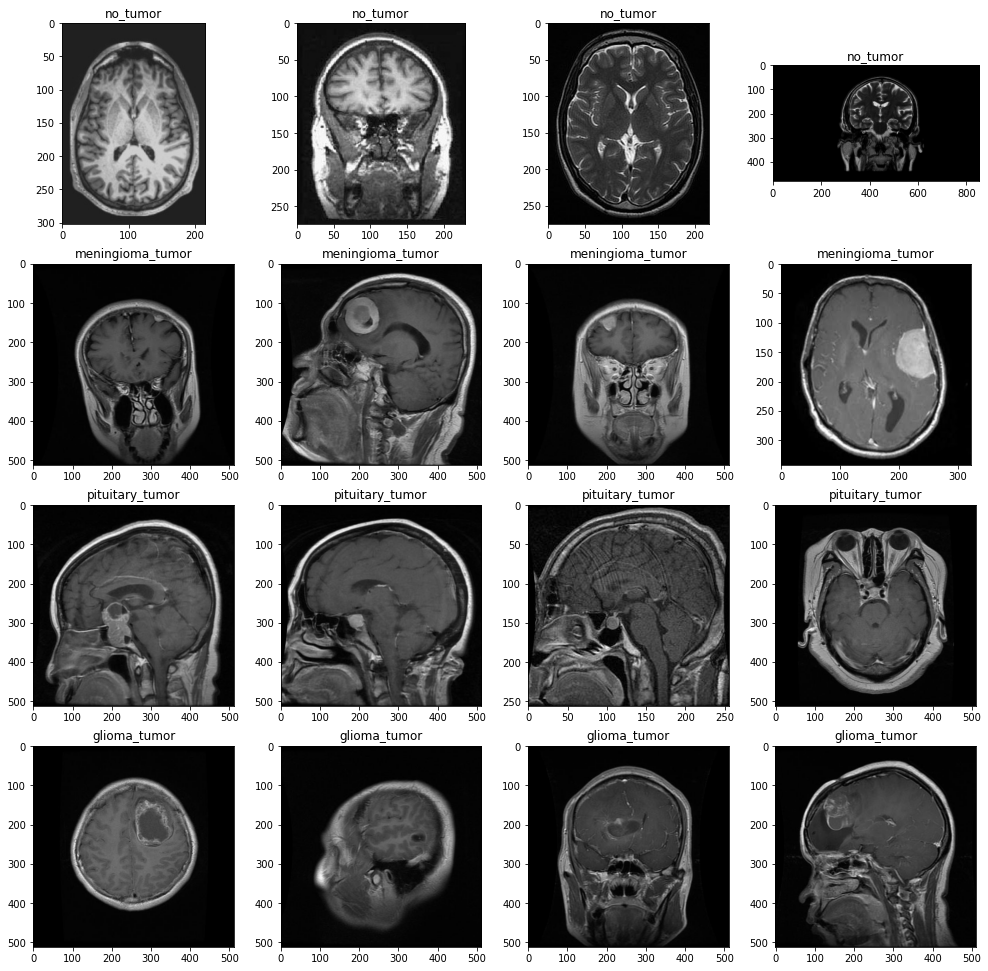

In [ ]:
train_dir = "/content/Coursera-Content/Brain-MRI/Training/" #dont fotget add slash in end of path
test_dir = "/content/Coursera-Content/Brain-MRI/Testing/" #dont fotget add slash in end of path

#store these folder names in a list format in a variable called classes
classes = os.listdir("/content/Coursera-Content/Brain-MRI/Training")

#create an empty dictionary
files_path_dict = {} 
'''
in this dict, the key will be the class name and 
the corresponding value will be a list of all the file names 
contained within a particular class folder
'''
for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir+c+'/'+x, os.listdir(train_dir+c)))


#plot the images so that can visualize them
#create matplotlib figure, with figure size as a 17 by 17
plt.figure(figsize=(17,17))

#declare a variable called index and will initialize it with zero
index = 0

for c in classes:
  random.shuffle(files_path_dict[c]) 
  '''random shuffling for whenever run this code, 
  I want that every time a new set of figures are generated 
  and random images are taken from the folders'''
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4,4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Create a Function to Crop Images

In the previous images shown, we will see that the images still have back area surrounding the brain MRI scan, and since these black area is presented most of the images, so it won't be contributing much to what classification task. So we should remove the black area from the image and can crop the image

Just copy the code from crop_image.py in Coursera-Content the directory

In [ ]:
def crop_image(image, plot=False): #if want to show the plot, set True
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting the image to grayscale
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0) #blur the images by applying the Gaussian Blur function
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1] #apply binary threshold on the image
    img_thresh = cv2.erode(img_thresh, None, iterations=2) #applying erosion on image
    img_thresh = cv2.dilate(img_thresh, None, iterations=2) #dilating the image

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find the countour. retrieving only the external boundaries
    contours = imutils.grab_contours(contours) #grabbing all the countours with that we find in previous code
    c = max(contours, key=cv2.contourArea) #find the biggest contour on the basis of contour area
    
    #position of the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #crop the images. extracting a new image on the basis of the positions
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    #if plot set True, then showing the plot and cropped images
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

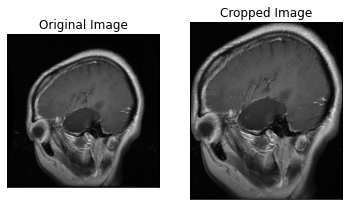

In [ ]:
example_img = cv2.imread("/content/Coursera-Content/Brain-MRI/Training/glioma_tumor/gg (100).jpg")
copped_image = crop_image(example_img, plot=True)

## Saving The Cropped Images 

I am going to crop all the images that are present in our data set and we will save them in the directories that we created in Task three

In [ ]:
# Crop the Training Images and Save it to the Directory we previously cretaed
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

100%|██████████| 901/901 [00:05<00:00, 170.14it/s]


In [ ]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

100%|██████████| 5/5 [00:00<00:00, 131.35it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [ ]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size = (224, 224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size = (224, 224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'validation')

test_data = datagen.flow_from_directory('/content/Test-Data/',
                                         target_size = (224, 224),
                                         class_mode = 'categorical')

Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [ ]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


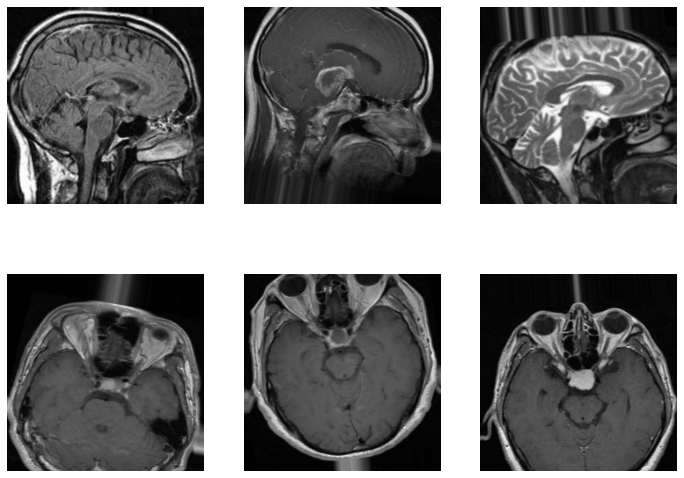

In [ ]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model 

In [ ]:
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
#
'''
use efficient net model and compile it.
why use it? because it does not have a lot of parameters 
but it still manages t give a decent accuracy
'''

model = effnet.output
model = GlobalAveragePooling2D()(model) #since haven't add top layers of the efficient net model
model = Dropout(0.5)(model) #add drop out layer, can manage overflitting
model = Dense(4, activation="softmax")(model) 
model = Model(inputs= effnet.input, outputs = model)

model.summary()

27025408/27018416 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Model Training and Model Evaluation

In [ ]:
# Train the 
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/7
82/82 [==============================] - 83s 523ms/step - loss: 0.8573 - accuracy: 0.6602 - val_loss: 1.0339 - val_accuracy: 0.6120

Epoch 00001: val_accuracy improved from -inf to 0.61196, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
82/82 [==============================] - 40s 491ms/step - loss: 0.3810 - accuracy: 0.8703 - val_loss: 0.6744 - val_accuracy: 0.7270

Epoch 00002: val_accuracy improved from 0.61196 to 0.72699, saving model to model.h5
Epoch 3/7
82/82 [==============================] - 41s 493ms/step - loss: 0.2336 - accuracy: 0.9215 - val_loss: 0.5906 - val_accuracy: 0.7684

Epoch 00003: val_accuracy improved from 0.72699 to 0.76840, saving model to model.h5
Epoch 4/7
82/82 [==============================] - 40s 489ms/step - loss: 0.1735 - accuracy: 0.9434 - val_loss: 0.3960 - val_accuracy: 0.8497

Epoch 00004: val_accuracy improved from 0.76840 to 0.84969, saving model to model.h5
Epoch 5/7
82/82 [==============================] - 40s 490ms/step - loss: 0.1170 - accuracy: 0.9610 - val_loss: 0.2970 - val_accuracy: 0.8911

Epoch 00005: val_accuracy improved from 0.84969 to 0.89110, saving model to model.h5
Epoch 6/7
82/82 [==============================] - 40s 489ms/step - loss: 0.0880 - accur

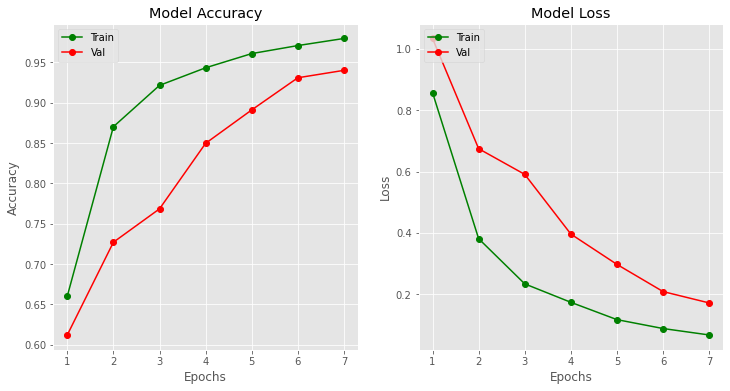

In [ ]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc="upper left")

plt.show()

In [ ]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 0s 434ms/step - loss: 0.5151 - accuracy: 0.9500


[0.5151478052139282, 0.949999988079071]

## Obtaining Predictions on Test Images

no_tumor


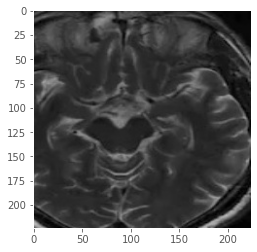

In [ ]:
# Obtain Predictions on Test Images
class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Data/no_tumor/1.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)